In [86]:
%load_ext edx_jupyter

The edx_jupyter extension is already loaded. To reload it, use:
  %reload_ext edx_jupyter


In [87]:
%reload_ext edx_jupyter

In [88]:
%vertica SELECT 'Connected to Vertica'

OPS_WAREHOUSE_PASSWORD: ········


,?column?
0,Connected to Vertica


In [89]:
from plotnine import *

# Forum Posts

In [90]:
%%vertica
DROP TABLE IF EXISTS user_forum_posts;
CREATE local TEMPORARY TABLE user_forum_posts
ON COMMIT PRESERVE ROWS AS
SELECT
    ua.date,
    ua.user_id,
    ua.course_id,
    ua.number_of_activities as num_forum_activities
FROM
    production.f_user_activity ua
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = ua.course_id
WHERE
    -- Include daily count of forum posts
    ua.activity_type = 'POSTED_FORUM'
    AND ua.number_of_activities > 0
    
    -- Exclude courses with no pacing_type
    AND cm.pacing_type IS NOT NULL
    
    -- Exclude courses from before 2015 and starting in the future
    AND cm.course_start_date BETWEEN '2015-01-01' AND NOW()
    
    -- Exclude white label courses
    AND cm.is_WL = 0;
    
SELECT COUNT(user_id) from user_forum_posts;

,COUNT
0,1263275


In [91]:
%%vertica
SELECT * from user_forum_posts LIMIT 10;

,date,user_id,course_id,num_forum_activities
0,2017-05-15,14665751,course-v1:PennX+SD1x+2T2017,1
1,2017-06-28,8378578,course-v1:LinuxFoundationX+LFS152x+3T2016,1
2,2017-01-25,6681648,course-v1:ETSx+TOEFLx+1T2017,1
3,2017-04-12,1824180,course-v1:NewcastleX+SWL101x+1T2017,1
4,2017-06-09,14884218,course-v1:TeachersCollegeX+EDSCI1x+2T2017,2
5,2017-06-07,14884218,course-v1:TeachersCollegeX+EDSCI1x+2T2017,1
6,2017-06-08,14884218,course-v1:TeachersCollegeX+EDSCI1x+2T2017,2
7,2017-06-07,14884218,course-v1:edX+DemoX.1+2T2017,1
8,2016-10-19,12347072,course-v1:HarvardX+GSE3x+2T2016,1
9,2017-02-07,6438002,course-v1:ETSx+TOEFLx+1T2017,1


In [92]:
%%vertica
SELECT
    course_id,
    COUNT(DISTINCT user_id) as num_users_posted_in_forums,
    SUM(num_forum_activities) as total_num_forum_posts
FROM
    user_forum_posts
GROUP BY
    course_id
ORDER BY
    total_num_forum_posts DESC
LIMIT 10

,course_id,num_users_posted_in_forums,total_num_forum_posts
0,course-v1:OECx+TESS101x+3T2016,14273,80575
1,course-v1:HarvardX+PH558x+2T2016,3600,53438
2,course-v1:IDBx+IDB6x+1T2017,4869,35120
3,course-v1:JaverianaX+ESC1.0x+1T2017,5495,30827
4,course-v1:OxfordX+OXBSG01x+1T2017,6315,29043
5,course-v1:UBCx+IndEdu200x+1T2017,3585,29004
6,course-v1:KULeuvenX+EWBCx+3T2016,1679,26583
7,course-v1:NewcastleX+NHI101x+3T2016,3411,25236
8,course-v1:ETSx+TOEFLx+3T2016,14876,25028
9,course-v1:MITx+6.00.1x+2T2016,4430,24075


In [93]:
%%vertica
DROP TABLE IF EXISTS course_forum_data;
CREATE local TEMPORARY TABLE course_forum_data
ON COMMIT PRESERVE ROWS AS
SELECT
    ret.course_id,
    ret.num_users_posted_in_forums,
    ret.total_num_forum_posts,
    css.sum_enrolls AS num_enrollees,
    (ret.num_users_posted_in_forums * 100 / css.sum_enrolls) AS percentage_users_posted_in_forums,
    (ret.total_num_forum_posts / css.sum_enrolls) AS forum_posts_per_user
FROM
(
    SELECT
        course_id,
        COUNT(DISTINCT user_id) as num_users_posted_in_forums,
        SUM(num_forum_activities) as total_num_forum_posts
    FROM
        user_forum_posts
    GROUP BY
        course_id
) AS ret
JOIN
    business_intelligence.course_stats_summary css
    ON css.course_id = ret.course_id
ORDER BY
    percentage_users_posted_in_forums DESC

,course_id,num_users_posted_in_forums,total_num_forum_posts


In [94]:
%%vertica -> forum_data
SELECT * from course_forum_data;

In [95]:
forum_data.head()

,course_id,num_users_posted_in_forums,total_num_forum_posts,num_enrollees,percentage_users_posted_in_forums,forum_posts_per_user
0,course-v1:UBCx+CW1.2x+3T2016,99,2667,131,75.572519083969465649,20.358778625954198473
1,course-v1:UBCx+CW1.1x+1T2017,153,3298,208,73.557692307692307692,15.855769230769230769
2,course-v1:UBCx+CW1.2x+1T2017,72,1980,98,73.469387755102040816,20.204081632653061224
3,course-v1:ASUx+GFA101x+2171A,364,699,496,73.387096774193548387,1.409274193548387097
4,course-v1:DelftX+IDEMC.3x+2T2017,33,670,50,66.000000000000000000,13.400000000000000000


# Bookings per enrollment by total number of forum posts

In [96]:
%%vertica -> df_all
SELECT
    cm.pacing_type,
    CASE
        WHEN fd.total_num_forum_posts >= 0 AND fd.total_num_forum_posts < 20 THEN 'total_1'
        WHEN fd.total_num_forum_posts >= 20 AND fd.total_num_forum_posts < 220 THEN 'total_2'
        WHEN fd.total_num_forum_posts >= 220 AND fd.total_num_forum_posts < 2000 THEN 'total_3'
        WHEN fd.total_num_forum_posts >= 2000 THEN 'total_4'
        ELSE 'error'
    END AS total_forum_posts_range,
    COUNT(*) AS num_courses,
    SUM(css.sum_bookings) / SUM(css.sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(css.sum_verifications) / SUM(css.sum_enrolls_vtr) AS vtr
FROM
    course_forum_data fd
JOIN
    business_intelligence.course_stats_summary css
    ON css.course_id = fd.course_id
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
GROUP BY 1, 2

In [97]:
df_all.head()

,pacing_type,total_forum_posts_range,num_courses,bookings_per_enrollment,vtr
0,self_paced,total_1,273,0.67137181915058088875,0.010210349670564137
1,self_paced,total_2,334,0.89845805439150475285,0.011316481361978986
2,self_paced,total_3,301,0.97512574906888480498,0.019150753510802720
3,self_paced,total_4,96,1.10596762579256666190,0.017349152752643687
4,instructor_paced,total_1,386,0.81041613770743105228,0.014838311789509997


In [98]:
df_all.set_index(['pacing_type', 'total_forum_posts_range'])

num_courses bookings_per_enrollment  \
pacing_type      total_forum_posts_range                                        
self_paced       total_1                          273  0.67137181915058088875   
                 total_2                          334  0.89845805439150475285   
                 total_3                          301  0.97512574906888480498   
                 total_4                           96  1.10596762579256666190   
instructor_paced total_1                          386  0.81041613770743105228   
                 total_2                          320  0.90003213003593157393   
                 total_3                          397  1.31187910349501717018   
                 total_4                          195  1.90901473191949869171   

                                                           vtr  
pacing_type      total_forum_posts_range                        
self_paced       total_1                  0.010210349670564137  
                 total_2                  0.011316481361978986  
                 total_3                  0.019150753510802720  
                 total_4                  0.017349152752643687  
instructor_paced total_1                  0.014838311789509997  
                 total_2                  0.015465622028162759  
                 total_3                  0.016032240793370677  
                 total_4                  0.027465945053952480

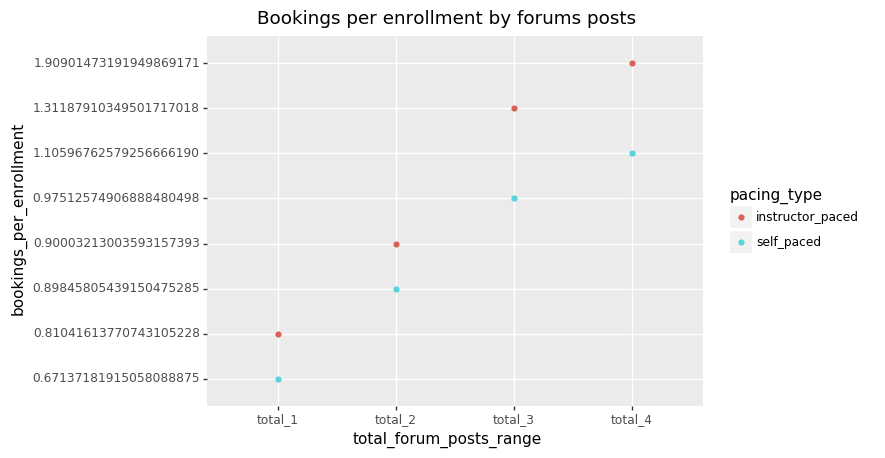

<ggplot: (8779781995391)>

In [99]:
(
    ggplot(
        df_all,
        aes(
            x='total_forum_posts_range',
            y='bookings_per_enrollment',
            color='pacing_type'
        )
    )
    + geom_point()
    + ggtitle('Bookings per enrollment by forums posts')
)

# Bookings per enrollment by percentage of users that post in forums

In [100]:
%%vertica -> fp_all
SELECT
    cm.pacing_type,
    fd.percentage_users_posted_in_forums,
    fd.forum_posts_per_user,
    COUNT(*) AS num_courses,
    SUM(css.sum_bookings) / SUM(css.sum_enrolls_vtr) AS bookings_per_enrollment,
    SUM(css.sum_verifications) / SUM(css.sum_enrolls_vtr) AS vtr
FROM
    course_forum_data fd
JOIN
    business_intelligence.course_stats_summary css
    ON css.course_id = fd.course_id
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
GROUP BY 1, 2, 3

In [101]:
fp_all.head()

,pacing_type,percentage_users_posted_in_forums,forum_posts_per_user,num_courses,bookings_per_enrollment,vtr
0,self_paced,5.042016806722689076,0.061047948591201186,1,0.12876915472071181414,0.002471576866040534
1,self_paced,4.874288425047438330,0.093216318785578748,1,0.79370256166982922201,0.016840607210626186
2,self_paced,0.245098039215686275,0.002450980392156863,1,0E-20,0.003076923076923077
3,instructor_paced,5.297029702970297030,0.331188118811881188,1,0.85806788511749347258,0.022454308093994778
4,instructor_paced,6.043956043956043956,0.203670479180683262,1,2.67405678537054860443,0.057940327237728585


In [102]:
fp_all['bookings_per_enrollment'] = fp_all.bookings_per_enrollment.astype(float)

In [103]:
fp_all.set_index(['pacing_type', 'percentage_users_posted_in_forums'])

forum_posts_per_user  \
pacing_type      percentage_users_posted_in_forums                         
self_paced       5.042016806722689076               0.061047948591201186   
                 4.874288425047438330               0.093216318785578748   
                 0.245098039215686275               0.002450980392156863   
instructor_paced 5.297029702970297030               0.331188118811881188   
                 6.043956043956043956               0.203670479180683262   
                 1.668737795135806852               0.079353807917628262   
                 0.143266475644699140               0.001719197707736390   
                 0.041771094402673350               0.002088554720133668   
                 0.945894816496405600               0.028755202421490730   
                 0.011227124733355788               0.000112271247333558   
                 0.044404973357015986               0.000444049733570160   
self_paced       0.135547272111148763               0.002372077261945103   
instructor_paced 0.001035389617112920               0.000020707792342258   
self_paced       0.369822485207100592               0.010586168639053254   
                 2.631578947368421053               0.052631578947368421   
instructor_paced 1.880064829821717990               0.035332252836304700   
                 8.050148465852853844               0.250082481029363246   
                 7.142857142857142857               0.071428571428571429   
                 0.569395017793594306               0.014768683274021352   
                 0.097499825893168048               0.001253569190055018   
                 0.906958561376075059               0.064894448788115715   
                 2.498560736902705815               0.109499136442141623   
                 0.306807286673058485               0.008053691275167785   
self_paced       0.478697941598851125               0.008137865007180469   
                 0.583482944344703770               0.008976660682226212   
instructor_paced 0.189214758751182592               0.001892147587511826   
                 0.034048348655090228               0.000340483486550902   
self_paced       4.853181076672104405               0.088499184339314845   
                 1.825715395571669041               0.054253528421597825   
                 1.042142631190467822               0.063688446803275808   
...                                                                  ...   
                 6.710030811365970558               0.170489558370421089   
                 0.237889273356401384               0.007569204152249135   
                 1.073197578425976885               0.018161805173362686   
                 0.417536534446764092               0.014196242171189979   
                 6.339385333198093113               0.248503905061365250   
instructor_paced 1.581073283323716099               0.061742642815926140   
                 3.388704318936877076               0.095016611295681063   
self_paced       0.917926565874730022               0.020608351331893449   
                 0.017745179226310186               0.000189281911747309   
instructor_paced 3.590909090909090909               0.124318181818181818   
                 2.982178986170006375               0.105669650693347376   
                 11.899728178797946240              0.364240410752038659   
                 4.791976225854383358               0.266158989598811293   
                 3.753938895739142348               0.129606795451431703   
                 1.460734387563655856               0.055749128919860627   
                 0.043991743088220365               0.000541436838008866   
                 2.665641419966679482               0.095732410611303345   
                 0.410798122065727700               0.005868544600938967   
self_paced       3.546798029556650246               0.056354679802955665   
instructor_paced 7.827698008337193145               0.232978230662343678   
                 4.76028

/workspace/src/plotnine/plotnine/layer.py:458: UserWarning: geom_point : Removed 48 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


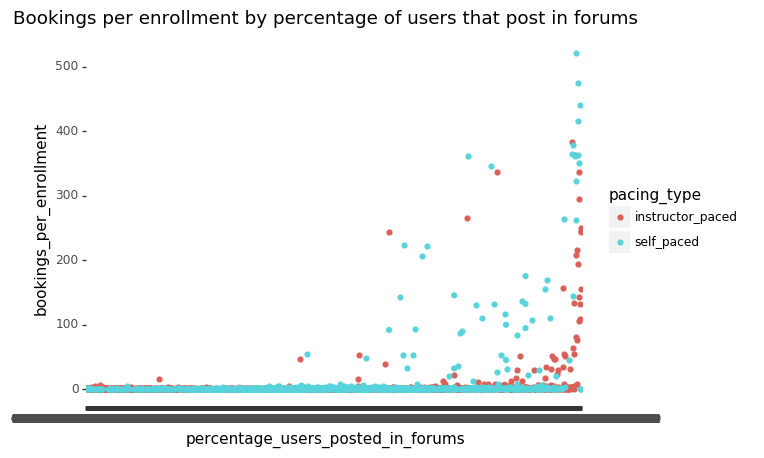

<ggplot: (-9223363257072797429)>

In [106]:
(
    ggplot(
        fp_all,
        aes(
            x='percentage_users_posted_in_forums',
            y='bookings_per_enrollment',
            color='pacing_type'
        )
    )
    + geom_point()
    + ggtitle('Bookings per enrollment by percentage of users that post in forums')
)

# Bookings per enrollment by forum posts per user

In [107]:
fp_all.set_index(['pacing_type', 'forum_posts_per_user'])

percentage_users_posted_in_forums  \
pacing_type      forum_posts_per_user                                     
self_paced       0.061047948591201186              5.042016806722689076   
                 0.093216318785578748              4.874288425047438330   
                 0.002450980392156863              0.245098039215686275   
instructor_paced 0.331188118811881188              5.297029702970297030   
                 0.203670479180683262              6.043956043956043956   
                 0.079353807917628262              1.668737795135806852   
                 0.001719197707736390              0.143266475644699140   
                 0.002088554720133668              0.041771094402673350   
                 0.028755202421490730              0.945894816496405600   
                 0.000112271247333558              0.011227124733355788   
                 0.000444049733570160              0.044404973357015986   
self_paced       0.002372077261945103              0.135547272111148763   
instructor_paced 0.000020707792342258              0.001035389617112920   
self_paced       0.010586168639053254              0.369822485207100592   
                 0.052631578947368421              2.631578947368421053   
instructor_paced 0.035332252836304700              1.880064829821717990   
                 0.250082481029363246              8.050148465852853844   
                 0.071428571428571429              7.142857142857142857   
                 0.014768683274021352              0.569395017793594306   
                 0.001253569190055018              0.097499825893168048   
                 0.064894448788115715              0.906958561376075059   
                 0.109499136442141623              2.498560736902705815   
                 0.008053691275167785              0.306807286673058485   
self_paced       0.008137865007180469              0.478697941598851125   
                 0.008976660682226212              0.583482944344703770   
instructor_paced 0.001892147587511826              0.189214758751182592   
                 0.000340483486550902              0.034048348655090228   
self_paced       0.088499184339314845              4.853181076672104405   
                 0.054253528421597825              1.825715395571669041   
                 0.063688446803275808              1.042142631190467822   
...                                                                 ...   
                 0.170489558370421089              6.710030811365970558   
                 0.007569204152249135              0.237889273356401384   
                 0.018161805173362686              1.073197578425976885   
                 0.014196242171189979              0.417536534446764092   
                 0.248503905061365250              6.339385333198093113   
instructor_paced 0.061742642815926140              1.581073283323716099   
                 0.095016611295681063              3.388704318936877076   
self_paced       0.020608351331893449              0.917926565874730022   
                 0.000189281911747309              0.017745179226310186   
instructor_paced 0.124318181818181818              3.590909090909090909   
                 0.105669650693347376              2.982178986170006375   
                 0.364240410752038659             11.899728178797946240   
                 0.266158989598811293              4.791976225854383358   
                 0.129606795451431703              3.753938895739142348   
                 0.055749128919860627              1.460734387563655856   
                 0.000541436838008866              0.043991743088220365   
                 0.095732410611303345              2.665641419966679482   
                 0.005868544600938967              0.410798122065727700   
self_paced       0.056354679802955665              3.546798029556650246   
instructor_paced 0.232978230662343678              7.827698008337193145   
                 0.251615096905814349              4.7602856171

/workspace/src/plotnine/plotnine/layer.py:458: UserWarning: geom_point : Removed 48 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


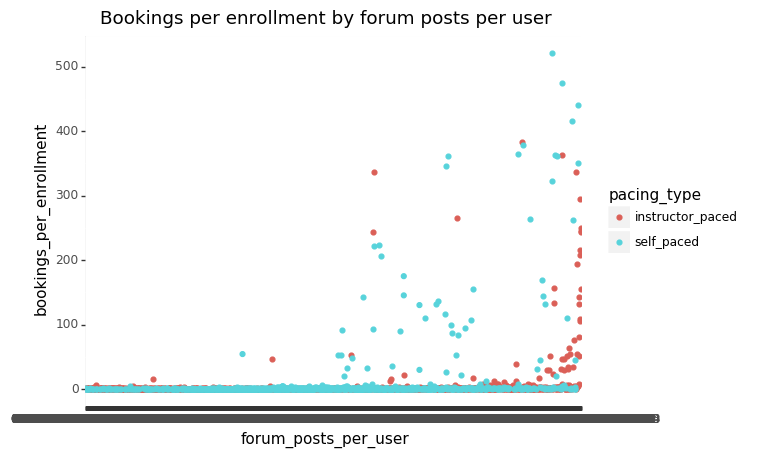

<ggplot: (8779784489287)>

In [108]:
(
    ggplot(
        fp_all,
        aes(
            x='forum_posts_per_user',
            y='bookings_per_enrollment',
            color='pacing_type'
        )
    )
    + geom_point()
    + ggtitle('Bookings per enrollment by forum posts per user')
)

# Problem submissions by Forum posts

In [109]:
%%vertica
DROP TABLE IF EXISTS user_problem_submissions;
CREATE local TEMPORARY TABLE user_problem_submissions
ON COMMIT PRESERVE ROWS AS
SELECT
    ua.date,
    ua.user_id,
    ua.course_id,
    ua.number_of_activities as num_problem_submissions
FROM
    production.f_user_activity ua
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = ua.course_id
WHERE
    -- Include daily count of problem submissions
    ua.activity_type = 'ATTEMPTED_PROBLEM'
    AND ua.number_of_activities > 0
    
    -- Exclude courses with no pacing_type
    AND cm.pacing_type IS NOT NULL
    
    -- Exclude courses from before 2015 and starting in the future
    AND cm.course_start_date BETWEEN '2015-01-01' AND NOW()
    
    -- Exclude white label courses
    AND cm.is_WL = 0;
    
SELECT COUNT(user_id) from user_problem_submissions;

,COUNT
0,9926932


In [110]:
%%vertica -> ps_all
SELECT
    cm.pacing_type,
    fd.percentage_users_posted_in_forums,
    fd.forum_posts_per_user,
    COUNT(*) AS num_courses,
    SUM(ups.num_problem_submissions) / SUM(css.sum_enrolls) AS prob_submissions_per_user
FROM
    course_forum_data fd
LEFT JOIN
    user_problem_submissions ups
    ON ups.course_id = fd.course_id
JOIN
    business_intelligence.course_stats_summary css
    ON css.course_id = fd.course_id
JOIN
    business_intelligence.course_master cm
    ON cm.course_id = css.course_id
GROUP BY 1, 2, 3

In [111]:
ps_all.head()

,pacing_type,percentage_users_posted_in_forums,forum_posts_per_user,num_courses,prob_submissions_per_user
0,instructor_paced,5.023286759813705921,0.114437791084497671,1592,0.006833067533275158
1,self_paced,0.289226319595083153,0.006507592190889371,884,0.005290485959109157
2,instructor_paced,2.116198537899191997,0.061562139284340131,3952,0.002555921149990731
3,instructor_paced,0.368346007604562738,0.007663973384030418,849,0.001018238298691818
4,self_paced,7.565770285247622936,0.152452896225864784,16163,0.000310238139382619


In [112]:
ps_all['prob_submissions_per_user'] = ps_all.prob_submissions_per_user.astype(float)

In [113]:
ps_all.set_index(['pacing_type', 'prob_submissions_per_user'])

percentage_users_posted_in_forums  \
pacing_type      prob_submissions_per_user                                     
instructor_paced 0.006833                               5.023286759813705921   
self_paced       0.005290                               0.289226319595083153   
instructor_paced 0.002556                               2.116198537899191997   
                 0.001018                               0.368346007604562738   
self_paced       0.000310                               7.565770285247622936   
instructor_paced 0.000202                               0.026908242891739169   
self_paced       0.024506                               0.325732899022801303   
instructor_paced NaN                                    0.860046911649726349   
                 0.000389                               0.045768917819365338   
self_paced       0.008180                               1.299504950495049505   
                 NaN                                    0.065487884741322855   
instructor_paced 0.000390                              16.383062920459042343   
                 0.000902                               0.009423294383716547   
self_paced       0.002332                               0.274574409665019220   
                 0.000651                               0.242242884115279114   
instructor_paced 0.000210                               0.118819724074196317   
self_paced       0.087772                              16.129032258064516129   
instructor_paced 0.000054                               1.892870000189476476   
                 0.000400                               2.055309942620637758   
self_paced       0.000430                               1.471927162367223065   
instructor_paced 0.000283                               0.244173140954495006   
                 0.002048                               2.731368500093861460   
                 0.000040                               0.011130899376669635   
self_paced       0.001922                               0.279720279720279720   
instructor_paced 0.004248                               3.589375448671931084   
self_paced       0.003264                               0.631911532385466035   
instructor_paced 0.001768                               2.413386249061460903   
                 0.000799                               0.013310262212165580   
self_paced       0.000056                               0.069937315443195358   
instructor_paced 0.000882                               0.087700065775049331   
...                                                                      ...   
self_paced       0.006201                               6.710030811365970558   
                 0.000971                               0.237889273356401384   
                 0.009589                               1.073197578425976885   
                 0.002601                               0.417536534446764092   
                 0.002173                               6.339385333198093113   
instructor_paced 0.001935                               1.581073283323716099   
                 0.014807                               3.388704318936877076   
self_paced       0.000411                               0.917926565874730022   
                 0.000040                               0.017745179226310186   
instructor_paced 0.005293                               3.590909090909090909   
                 0.000063                               2.982178986170006375   
                 0.006293                              11.899728178797946240   
                 0.003378                               4.791976225854383358   
                 0.000820                               3.753938895739142348   
self_paced       0.007680                               0.214132762312633833   
instructor_paced 0.000051                               0.043991743088220365   
                 0.002142                               2.665641419966679482   
                 NaN                       

/workspace/src/plotnine/plotnine/layer.py:458: UserWarning: geom_point : Removed 185 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


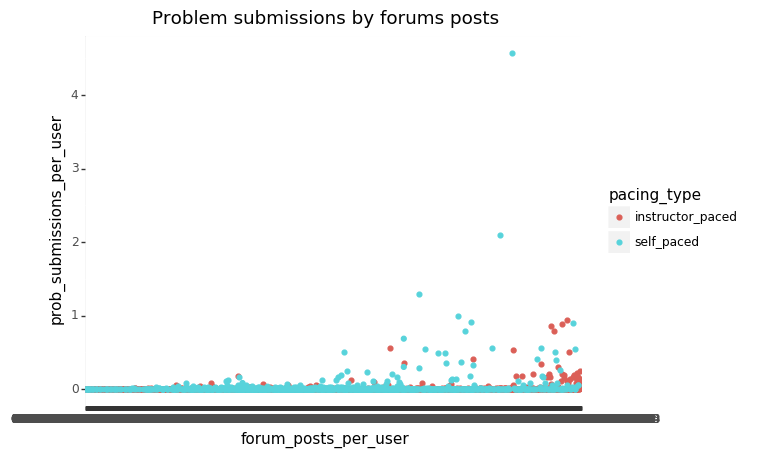

<ggplot: (8779782113505)>

In [114]:
(
    ggplot(
        ps_all,
        aes(
            x='forum_posts_per_user',
            y='prob_submissions_per_user',
            color='pacing_type'
        )
    )
    + geom_point()
    + ggtitle('Problem submissions by forums posts')
)

/workspace/src/plotnine/plotnine/layer.py:458: UserWarning: geom_point : Removed 185 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


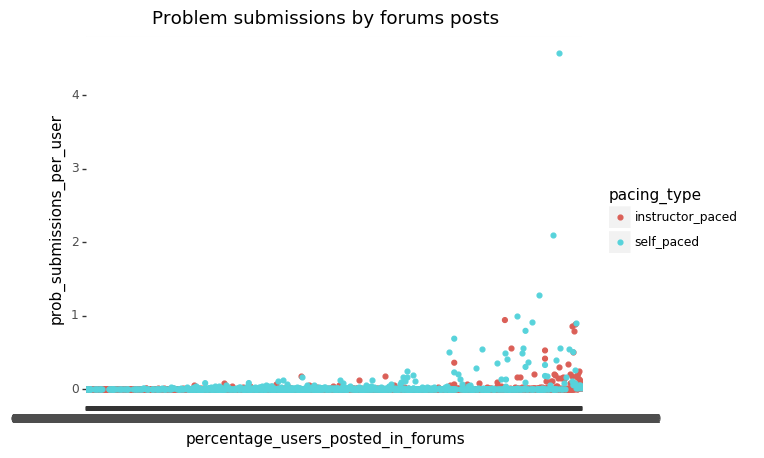

<ggplot: (-9223363257069749034)>

In [115]:
(
    ggplot(
        ps_all,
        aes(
            x='percentage_users_posted_in_forums',
            y='prob_submissions_per_user',
            color='pacing_type'
        )
    )
    + geom_point()
    + ggtitle('Problem submissions by forums posts')
)